In [1]:
import os
import sys
import PATH
import numpy as np
import pandas as pd
import utils

import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

from importlib import reload
import analysis_for_MTL as A_MTL
import ribo_public.parse_ribosome as Pribo
from sklearn import preprocessing

from models import Backbone
from models import reader
from models import train_val
from models import Cross_stitch
from models.popen import Auto_popen
from models.loss import Dynamic_Task_Priority,Dynamic_Weight_Averaging

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset,DataLoader,random_split

/home/wergillius/Project/UTR_VAE


In [2]:
import logomaker

In [3]:
reload(reader)

<module 'models.reader' from '/home/wergillius/Project/UTR_VAE/models/reader.py'>

## read data

<font size=4 color='orange'>**load dict**

In [4]:
a5b5_config="/home/wergillius/Project/UTR_VAE/log/CrossStitch/CrossStitch_Model_MTL/a5b5/a5b5_g2_11.ini"
logger = utils.setup_logs('test.log')
a5b5_dict = A_MTL.read_main_(a5b5_config,logger)

model = a5b5_dict['model']
a5b5_popen = a5b5_dict['popen']

 	 	 ==============<<<  Experiment detected  >>>============== 	 	 

 	 	 ==============<<<  Experiment detected  >>>============== 	 	 

 	 	 ==============<<< encoder load from >>>============== 	 	 

 	 	 ==============<<< encoder load from >>>============== 	 	 

 	/data/users/wergillius/UTR_VAE/pth/RL_regressor_MTL/test_run/RL_test-model_best.pth

 	/data/users/wergillius/UTR_VAE/pth/RL_regressor_MTL/test_run/RL_test-model_best.pth

 	 	 ==============<<< encoder load from >>>============== 	 	 

 	 	 ==============<<< encoder load from >>>============== 	 	 

 	/data/users/wergillius/UTR_VAE/pth/Reconstruction_MTL/test_run/kld1e_5-model_best.pth

 	/data/users/wergillius/UTR_VAE/pth/Reconstruction_MTL/test_run/kld1e_5-model_best.pth

 	 	 ==============<<< encoder load from >>>============== 	 	 

 	 	 ==============<<< encoder load from >>>============== 	 	 

 	/data/users/wergillius/UTR_VAE/pth/Motif_detection_MTL/test_run/eight_motif_test-model_best.pth

 	/data/users/wergill

<font size=4 color='orange'>**Read Dataset**

In [5]:
# read in data
data_dir = "/data/users/wergillius/UTR_VAE/Ex_data"
unmod1_df = pd.read_csv(os.path.join(data_dir,"GSM3130435_egfp_unmod_1.csv"))
design_df = pd.read_csv(os.path.join(data_dir,"GSM3130443_designed_library.csv"))
vleng_df  = pd.read_csv(os.path.join(data_dir,"GSM4084997_varying_length_25to100.csv"))

extram_df = design_df[(design_df.scaled_rl < -1.3)|(design_df.scaled_rl > 1.1)]

/home/wergillius/.conda/envs/pytorch/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (32,33,34,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
setting_name = os.path.dirname(a5b5_config)
RL_latent = np.load(os.path.join(setting_name,"a5b5_g2_11_tsne","cs_RL_tower.npy"))

## plot latent

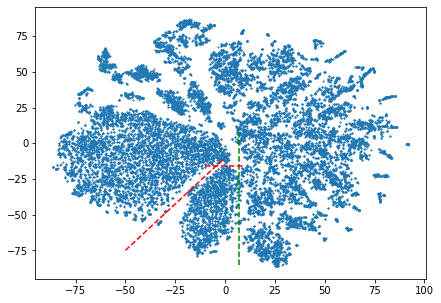

In [25]:
plt.figure(figsize=(7,5))
plt.scatter(RL_latent[:,0],RL_latent[:,1],s=1)
plt.plot([-50,0],[-75,-10],"--",color='red')
plt.plot([7,7],[-85,10],"--",color='green')
plt.plot([-10,10],[-16,-16],"--",color='red')

In [15]:
def plot_RL_latent(Tsne_down,c,emphasize=None,**kwargs):
    plt.figure(figsize=(9,8))

    plt.scatter(Tsne_down[:,0],Tsne_down[:,1],s=6,c=c,**kwargs);
#     plt.colorbar()
    plt.xticks([],fontsize=6)
    plt.yticks([],fontsize=6)
    if emphasize is not None:
        for index in emphasize:
            plt.scatter(Tsne_down[index,0],Tsne_down[index,1],marker='p',s=358,color='yellow',linewidth=1,edgecolor='black')
#     plt.axis("off")
    ax = plt.gca()
    ax.set(frame_on=False)
#     plt.xlabel("T-SNE1");
#     plt.ylabel("T-SNE2");
#     plt.title("hidden vairables of TE-prediction backbone");

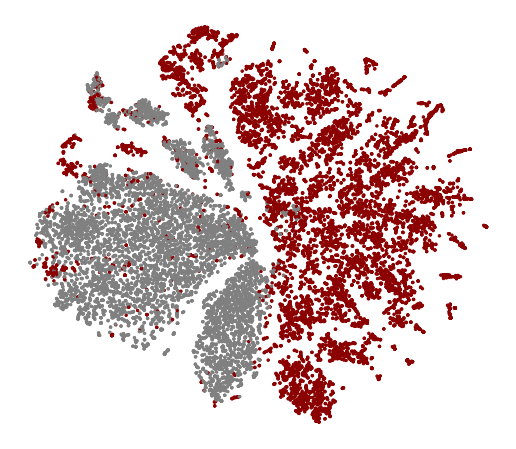

In [17]:
c_label = [['grey','darkred'][i] for i in extram_df.with_uAUG.values]
plot_RL_latent(RL_latent,c=c_label)

## Saliency map

In [7]:
def get_input_grad(test_X,index):
    
    # process X
    sampled_X = test_X[index].unsqueeze(0)
    sampled_X.requires_grad = True
    # forward
    sampled_out = model(sampled_X)['RL']

    # auto grad part
    external_grad = torch.ones_like(sampled_out)
    sampled_out.backward(gradient=external_grad,retain_graph=True) # define \frac{d out}{ }
    print(sampled_out)
    return sampled_X,sampled_X.grad

In [8]:
def seq_logo_df(sampled_X):
    
    if len(sampled_X.shape) == 2:
        sampled_X = sampled_X.unsqueeze(0)
        
    X = sampled_X[0].detach().cpu().numpy()[:50]
    df = pd.DataFrame(X,columns=['A', 'C', 'G', 'T'])
    return df

In [9]:
extrem_loader = reader.loader_from_df(extram_df,a5b5_popen)

In [10]:
extrem_iter = iter(extrem_loader)
count = -1

In [990]:
true_index_list=[]

<font size=5 color='orange'>**iter through all sampled**

In [1352]:
extram_df.iloc[11934,15]

1074

3032
tensor([[8.0463]], device='cuda:3', grad_fn=<AddmmBackward>)
24
utr          CCATCGACAATTTTTTTTTACGTCTGAGCAACCTCATGATGCTTGC...
total                                                     1197
rl                                                     1.23314
scaled_rl                                             -2.97126
Name: 15788, dtype: object


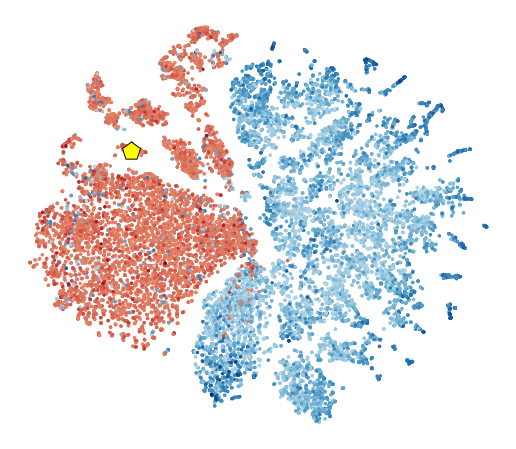

In [1486]:
model.eval()
data = next(extrem_iter)
count += 1
test_X,test_y = train_val.put_data_to_cuda(data,a5b5_popen)


max_pos = torch.argmin(test_y[:,0]).item()
true_index = count*126+max_pos
print(true_index)
true_index_list.append(true_index)

sampled_X, X_grad = get_input_grad(test_X,max_pos)

print(count)
print(extram_df.iloc[true_index,[0,15,31,41]])

plot_RL_latent(RL_latent,c=extram_df.scaled_rl.values,emphasize=[true_index])

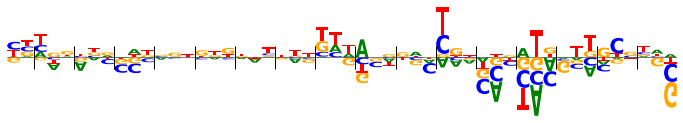

In [1487]:
X_grad_df = seq_logo_df(X_grad)

# create Logo object
nn_logo = logomaker.Logo(X_grad_df,figsize=(12,2))
nn_logo.ax.axis('off')
xs = [i-0.5 for i in range(2,50,3)]
ys = np.zeros_like(xs)
nn_logo.ax.plot(xs, ys, marker='|', linewidth=0, markersize=23, color='k')
# nn_logo.ax.set_ylabel('saliency', labelpad=-1)

Text(0, 0.5, 'saliency')

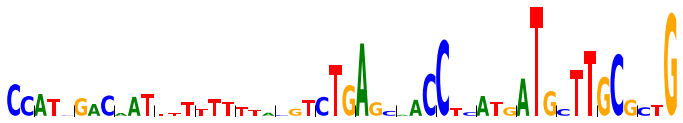

In [1488]:
with torch.no_grad():
    grad_X = torch.mul(sampled_X,X_grad.abs())

# create Logo object
grad_adj_df = seq_logo_df(grad_X)
nn_logo = logomaker.Logo(grad_adj_df,figsize=(12,2))
nn_logo.ax.axis('off')
xs = [i-0.5 for i in range(2,50,3)]
ys = np.zeros_like(xs)
nn_logo.ax.plot(xs, ys, marker='|', linewidth=0, markersize=23, color='k')
# nn_logo.ax.set(frame_on=False)
nn_logo.ax.set_ylabel('saliency', labelpad=-1)

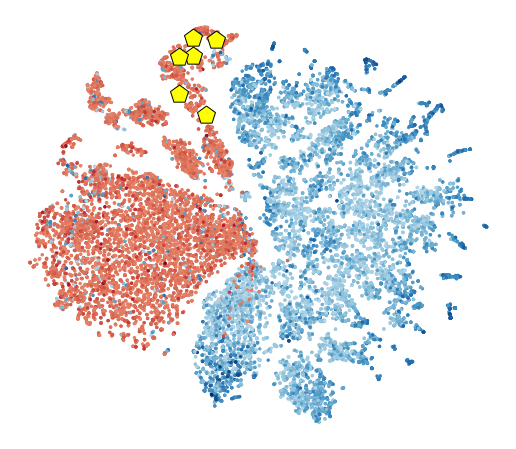

In [14]:
plot_RL_latent(RL_latent,c=extram_df.scaled_rl.values,emphasize=[4093,7014,3927,5338,10150,5161])

In [1126]:
print(true_index_list)

[73, 199, 253, 418, 557, 673, 778, 941, 1122, 1183, 1265, 1394, 1543, 1675, 1844, 1992, 2027, 2245, 2277, 2487, 2540, 2750, 2777, 2970, 3066, 3201, 3358, 3424, 3589, 3676, 3812, 3927, 4093, 4183, 4322, 4458, 4549, 4750, 4791, 5002, 5161, 5223, 5338, 5433, 5569, 5702, 5833, 6039, 6155, 6267, 6422, 6509, 6581, 6720, 6822, 7014, 7073, 7237, 7338, 7450, 7583, 7778, 7897, 8038, 8126, 8300, 8403, 8547, 8692, 8754, 8890, 9068, 9161, 9245, 9351, 9497, 9662, 9744, 9874, 9978, 10150, 10213, 10377, 10563, 10641, 10732, 10949, 11007, 11174, 11316, 11343, 11540]


In [12]:
def plot_RL_latent(Tsne_down,c,emphasize=None,**kwargs):
    plt.figure(figsize=(9,8))

    plt.scatter(Tsne_down[:,0],Tsne_down[:,1],s=6,c=c,cmap='RdBu_r',**kwargs);
#     plt.colorbar()
    plt.xticks([],fontsize=6)
    plt.yticks([],fontsize=6)
    if emphasize is not None:
        for index in emphasize:
            plt.scatter(Tsne_down[index,0],Tsne_down[index,1],marker='p',s=358,color='yellow',linewidth=1,edgecolor='black')
#     plt.axis("off")
    ax = plt.gca()
    ax.set(frame_on=False)
#     plt.xlabel("T-SNE1");
#     plt.ylabel("T-SNE2");
#     plt.title("hidden vairables of TE-prediction backbone");